In [1]:
# Attempt at blob detection in 3d images
import skimage as sk
import numpy as np
from skimage import io
from skimage import feature
import pandas as pd
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
import matplotlib.pyplot as plt
%matplotlib inline

img_file = '/Users/jwilmot/Desktop/SampleGFP.tif'
img_raw = sk.io.imread(img_file)

In [2]:
# takes image, min_sigma (affects minimum cell size found), max_sigma (affects max cell size found),
# threshold (affects how bright cells must be to be detected)

# Laplacian of Gaussian
def detect_blobs_3dlog(image, min_sigma=10, max_sigma=20, threshold=.003):
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            log_cells = sk.feature.blob_log(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
        else:
            log_cells = np.append(log_cells, sk.feature.blob_log(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold), axis = 0)
    return log_cells

# Determinant of Hessian
def detect_blobs_3dhess(image, min_sigma=10, max_sigma=20, threshold=.003):
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            hess_cells = sk.feature.blob_doh(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
        else:
            hess_cells = np.append(hess_cells, sk.feature.blob_doh(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold), axis = 0)
    return hess_cells

# Difference of Gaussian
def detect_blobs_3ddog(image, min_sigma=10, max_sigma=20, threshold=.003):
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            dog_cells = sk.feature.blob_dog(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
        else:
            dog_cells = np.append(dog_cells, sk.feature.blob_dog(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold), axis = 0)
    return dog_cells

In [3]:
def plot_blobs(blobs, color, size_mod, fill = True):
    for blob in blobs:
        y, x, size = blob
        c = plt.Circle((x, y), size*size_mod, color=color, linewidth=2, fill=fill)
        ax.add_patch(c)
        

In [14]:
# Function for perofrming unsupervised clustering of centroids to get a single centroid for each cell.
# takes vector of x values, vector of y values, and the maximum distance btwn centroids that form a cluster.

def cluster_centroids(x, y, max_dist):
    xy_array = np.column_stack((x,y))
    coordinates = pd.DataFrame(xy_array, columns = ['x','y'])
    
    #create matrix of distances between all centroids
    dist_mat = dist.squareform(dist.pdist(coordinates.values))
    
    #perform clustering
    link_mat = hier.linkage(dist_mat)
    cluster_idx = hier.fcluster(link_mat, max_dist, criterion = 'distance')
    
    #make organized dataframe with labeled clusters
    coordinates['new_label'] = cluster_idx
    coordinates.set_index('new_label', drop=True, append=False, inplace=True)
    coordinates.index.name = 'label'
    coordinates = coordinates.sort_index()
    
    #compute a final centroid for each cell by averaging the x y coords of each cluster
    coordinates = coordinates.groupby(level ='label').mean()
    return coordinates

In [18]:
cells1 = detect_blobs_3dlog(img_raw)
cells2 = detect_blobs_3ddog(img_raw)
cells3 = detect_blobs_3dhess(img_raw)

In [19]:
all_cells = np.concatenate((cells1, cells2, cells3))
all_cells

array([[ 540.        ,  645.        ,   15.55555556],
       [ 498.        ,  560.        ,   10.        ],
       [ 479.        ,  701.        ,   11.11111111],
       ..., 
       [   0.        ,  514.        ,   10.        ],
       [   0.        ,   92.        ,   16.        ],
       [   0.        ,    0.        ,   16.        ]])

In [20]:
centroids = cluster_centroids(all_cells[:,1], all_cells[:,0], 100)

/Users/jwilmot/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


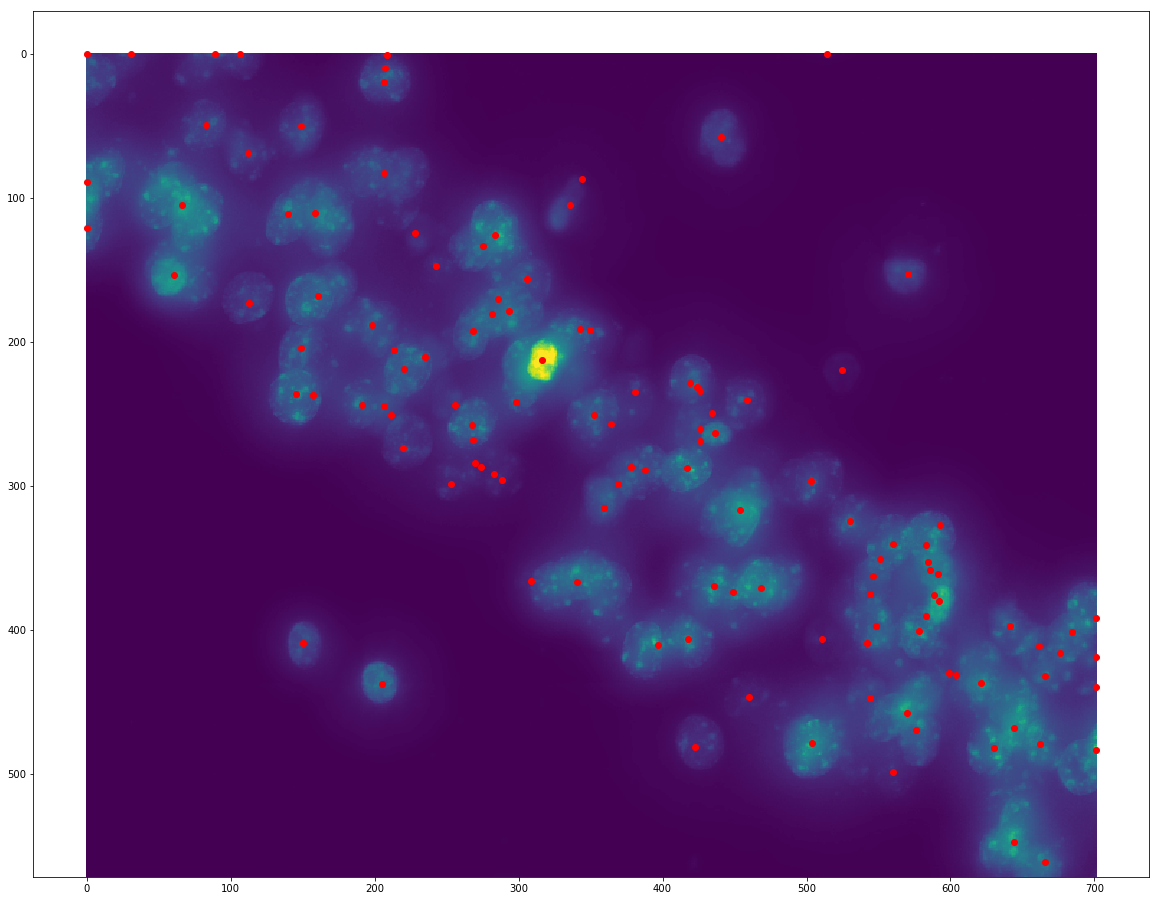

In [22]:
img_max = img_raw.max(axis=0)
plt.figure(figsize = (20,20))
plt.imshow(img_max)
plt.scatter(centroids['x'], centroids['y'], c = 'r')